In [1]:
import pandas as pd
import pandasql as psql

In [73]:
# Convert CSV file to parquet

df = pd.read_csv("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv")
df.to_parquet("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.parquet", engine='pyarrow')

# Explore Dataset

In [107]:
attendance_df = pd.read_parquet("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.parquet")

attendance_df.head()

,epi_week,disease,no._of_cases
0,2012-W01,Acute Upper Respiratory Tract infections,2932
1,2012-W01,Acute Conjunctivitis,120
2,2012-W01,Acute Diarrhoea,491
3,2012-W01,Chickenpox,18
4,2012-W02,Acute Upper Respiratory Tract infections,3189


In [94]:
acute_conjunctivitis_df = attendance_df[attendance_df["disease"] == "Acute Conjunctivitis"].reset_index(drop=True)
acute_diarrhoea_df = attendance_df[attendance_df["disease"] == "Acute Diarrhoea"].reset_index(drop=True)
acute_urti_df = attendance_df[attendance_df["disease"] == "Acute Upper Respiratory Tract infections"].reset_index(drop=True)

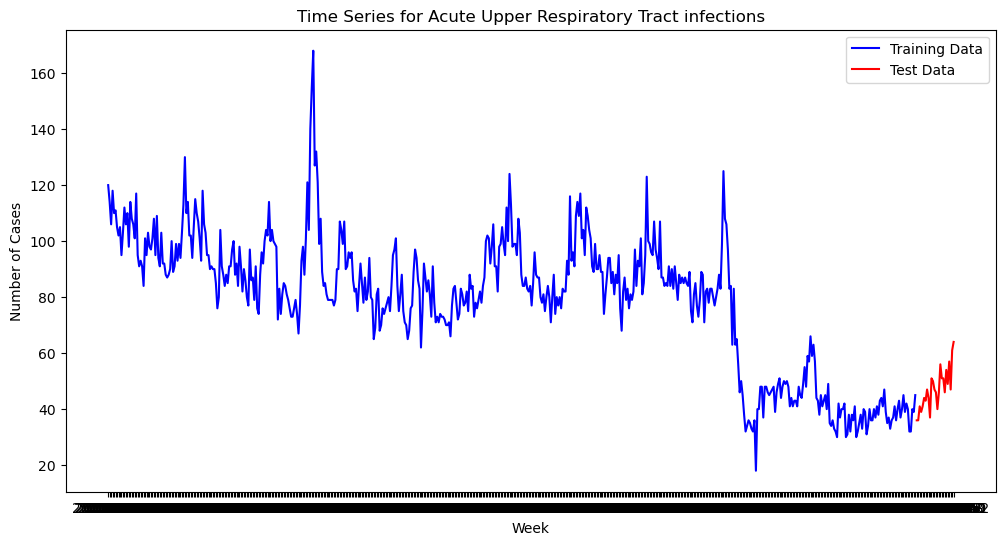

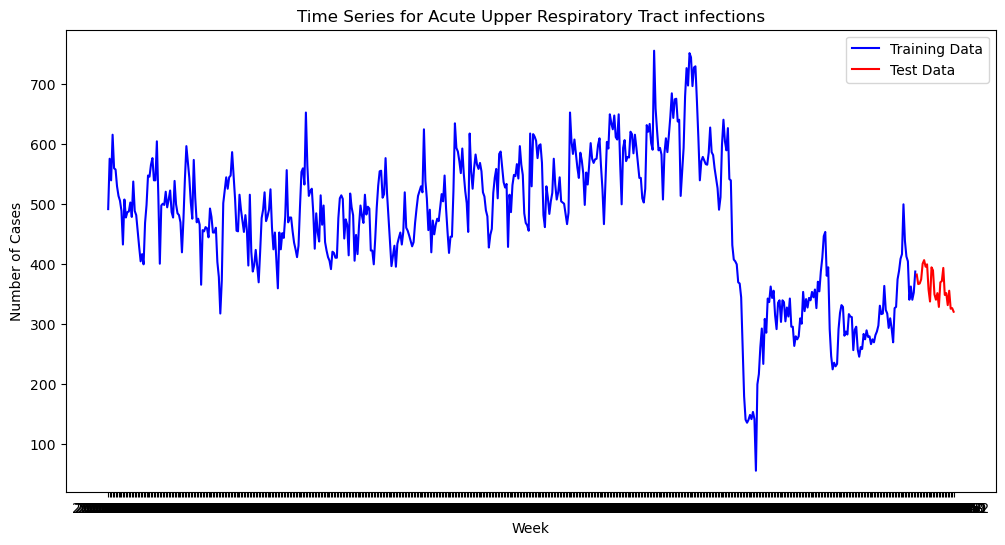

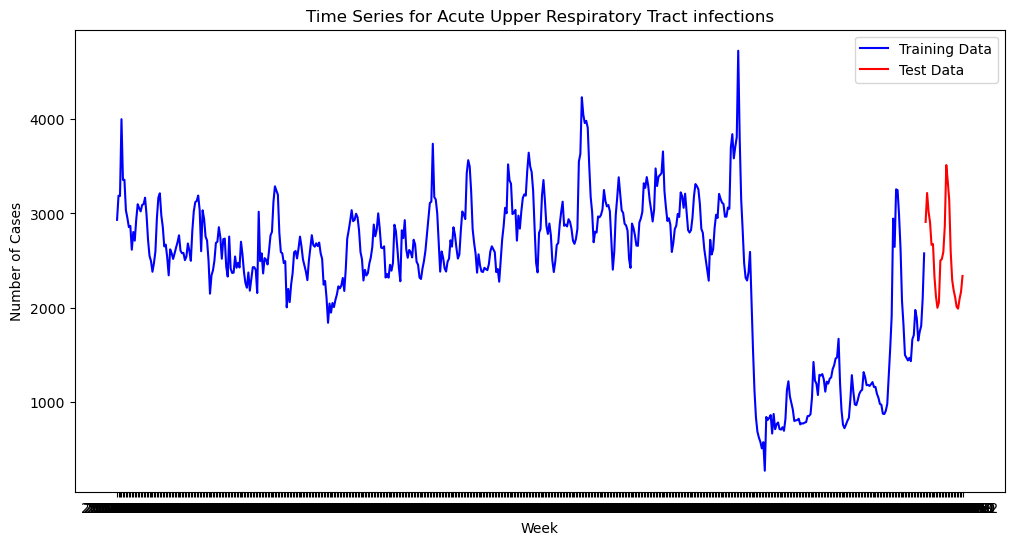

In [103]:
import matplotlib.pyplot as plt

for data in [acute_conjunctivitis_df, acute_diarrhoea_df, acute_urti_df]:
    train_data = data[data['epi_week'] <= '2022-W26']
    test_data = data[data['epi_week'] > '2022-W26']
    
    # Plot training data in blue
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['no._of_cases'], label='Training Data', color='blue')

    # Plot test data in red
    plt.plot(test_data['no._of_cases'], label='Test Data', color='red')

    # Add labels, title, and legend
    plt.title(f'Time Series for {disease}')
    plt.xlabel('Week')
    plt.ylabel('Number of Cases')
    plt.legend()
    
    # Show plot
    plt.show()

# Check for Staionarity, Trend and/or Seasonality

The ACF plot shows there is a strong trend and non-stationarity.

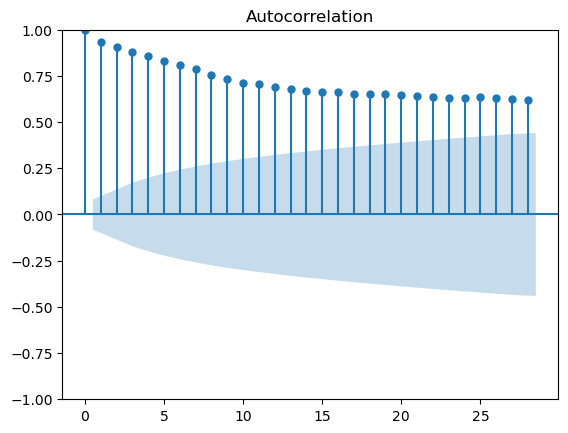

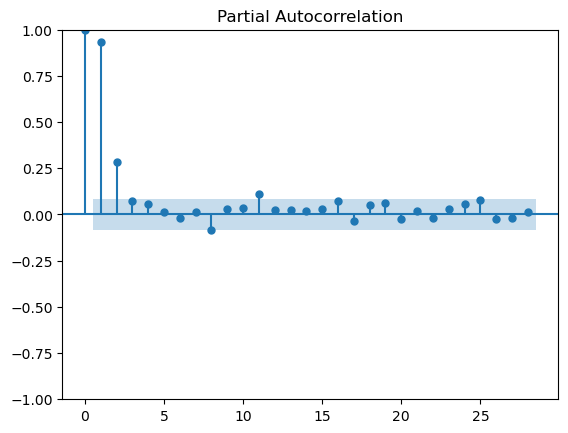

In [86]:
# ACF and PACF Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(acute_conjunctivitis_df["no._of_cases"])
pacf = plot_pacf(acute_conjunctivitis_df["no._of_cases"])

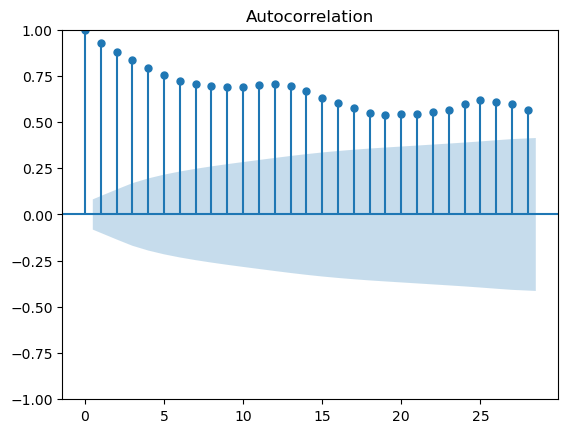

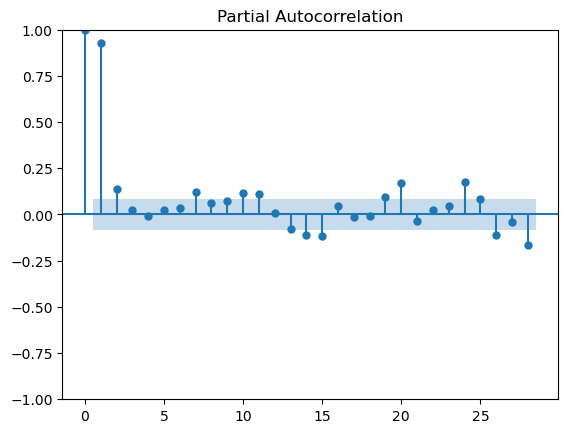

In [87]:
acf = plot_acf(acute_diarrhoea_df["no._of_cases"])
pacf = plot_pacf(acute_diarrhoea_df["no._of_cases"])

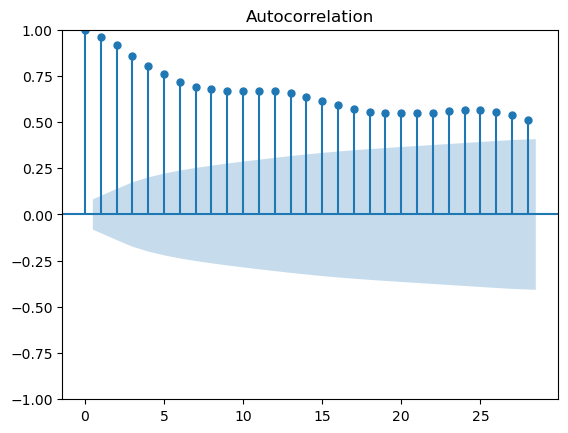

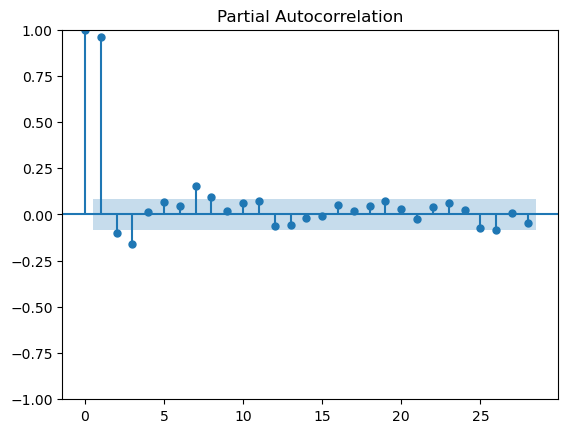

In [88]:
acf = plot_acf(acute_urti_df["no._of_cases"])
pacf = plot_pacf(acute_urti_df["no._of_cases"])

# Train Models

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from tqdm import tqdm

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

results = []

disease_data = {
    'Acute Conjunctivitis': acute_conjunctivitis_df,
    'Acute Diarrhoea': acute_diarrhoea_df,
    'Acute URTI': acute_urti_df
}

for disease_name, disease_df in disease_data.items():
    # Split train and test dataset for each disease
    train_data = disease_df[disease_df["epi_week"] <= "2022-W26"].drop(columns=["disease", "epi_week"])
    test_data = disease_df[disease_df["epi_week"] > "2022-W26"].drop(columns=["disease", "epi_week"])

    for p in tqdm(p_values, desc=f"Processing p values for {disease_name}..."):
        for d in d_values:
            for q in q_values:
                model = SARIMAX(train_data.values, order=(p, d, q), seasonal_order=(1, 1, 1, seasonal_period))
                model_fit = model.fit(disp=0)
                forecast = model_fit.forecast(steps=len(test_data))
                mse = mean_squared_error(test_data.values, forecast)
                results.append({
                    'disease': disease_name,
                    'p': p,
                    'd': d,
                    'q': q,
                    'MSE': mse
                })

results_df = pd.DataFrame(results)
print(tabulate(results_df, headers="keys", tablefmt="grid"))

Processing p values for Acute Conjunctivitis...:  67%|▋| 2/3 [02:28<01:19, 79.09/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Processing p values for Acute Conjunctivitis...: 100%|█| 3/3 [04:23<00:00, 87.84
Processing p values for Acute Diarrhoea...:  67%|▋| 2/3 [02:10<01:06, 66.38s/it]/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing p values for Acute URTI...:   0%|  

+----+----------------------+-----+-----+-----+------------------+
|    | disease              |   p |   d |   q |              MSE |
+====+======================+=====+=====+=====+==================+
|  0 | Acute Conjunctivitis |   0 |   0 |   0 |    144.778       |
+----+----------------------+-----+-----+-----+------------------+
|  1 | Acute Conjunctivitis |   0 |   0 |   1 |    141.683       |
+----+----------------------+-----+-----+-----+------------------+
|  2 | Acute Conjunctivitis |   0 |   0 |   2 |    128.142       |
+----+----------------------+-----+-----+-----+------------------+
|  3 | Acute Conjunctivitis |   0 |   1 |   0 |    301.589       |
+----+----------------------+-----+-----+-----+------------------+
|  4 | Acute Conjunctivitis |   0 |   1 |   1 |    254.956       |
+----+----------------------+-----+-----+-----+------------------+
|  5 | Acute Conjunctivitis |   0 |   1 |   2 |    254.721       |
+----+----------------------+-----+-----+-----+---------------

# Feature Engineering

# Evaluation

Best parameters for each disease:
* Acute Conjunctivitis: (2, 0, 0)
* Acute Diarrhoea: (2, 0, 0)
* Acute URTI: (0, 1, 2)

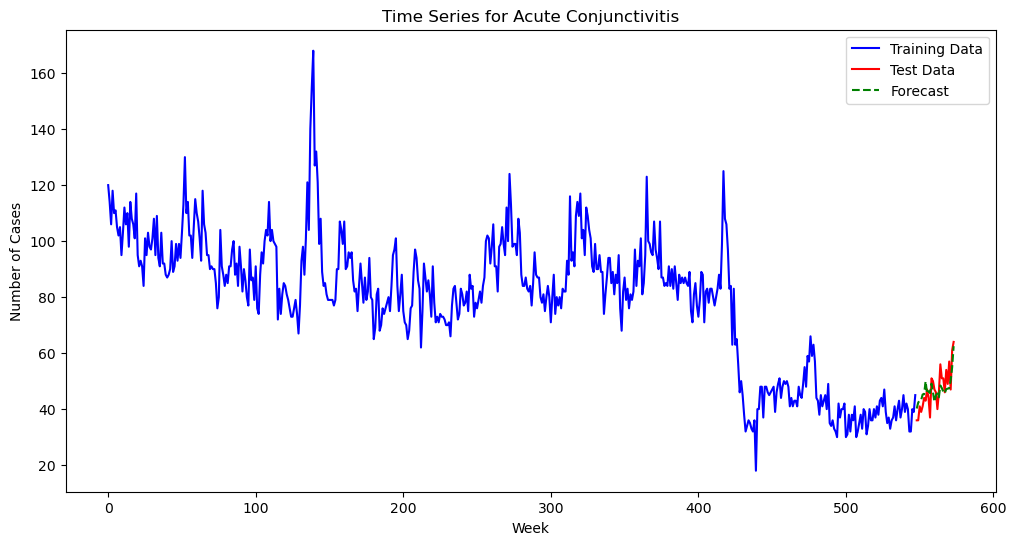

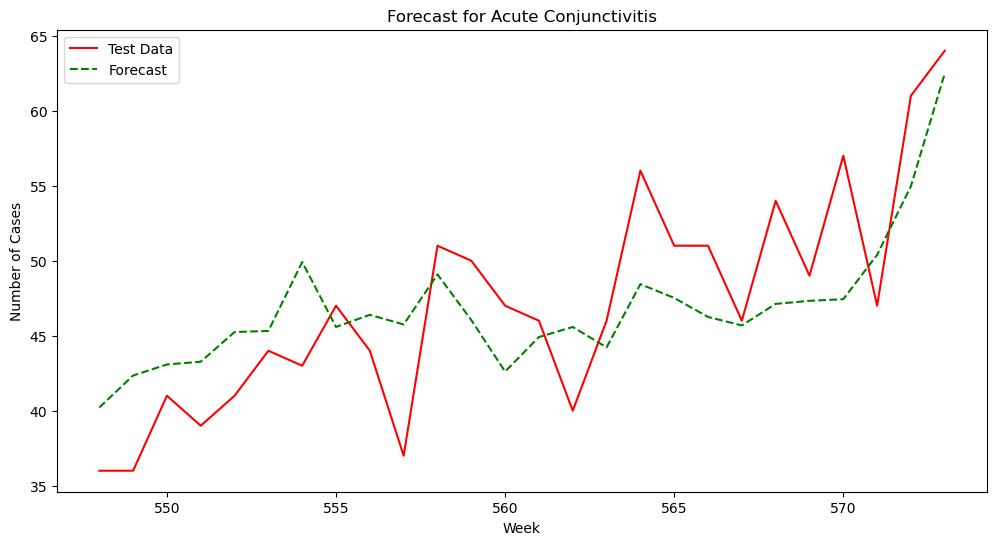

In [113]:
train_acute_conjuntivitis = acute_conjunctivitis_df[acute_conjunctivitis_df["epi_week"] <= "2022-W26"].drop(columns=["disease", "epi_week"])
test_acute_conjuntivitis = acute_conjunctivitis_df[acute_conjunctivitis_df["epi_week"] > "2022-W26"].drop(columns=["disease", "epi_week"])
acute_conjunctivitis_model = SARIMAX(
    train_acute_conjuntivitis.values, 
    order=(2, 0, 0), 
    seasonal_order=(1, 1, 1, seasonal_period)
)
model_fit = acute_conjunctivitis_model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_conjuntivitis))

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_acute_conjunctivitis.index, train_acute_conjunctivitis['no._of_cases'], label='Training Data', color='blue')

# Plot test data
plt.plot(test_acute_conjunctivitis.index, test_acute_conjunctivitis['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_conjunctivitis.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Time Series for Acute Conjunctivitis')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()

# Plotting the second plot
plt.figure(figsize=(12, 6))

# Plot test data
plt.plot(test_acute_conjunctivitis.index, test_acute_conjunctivitis['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_conjunctivitis.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Forecast for Acute Conjunctivitis')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()

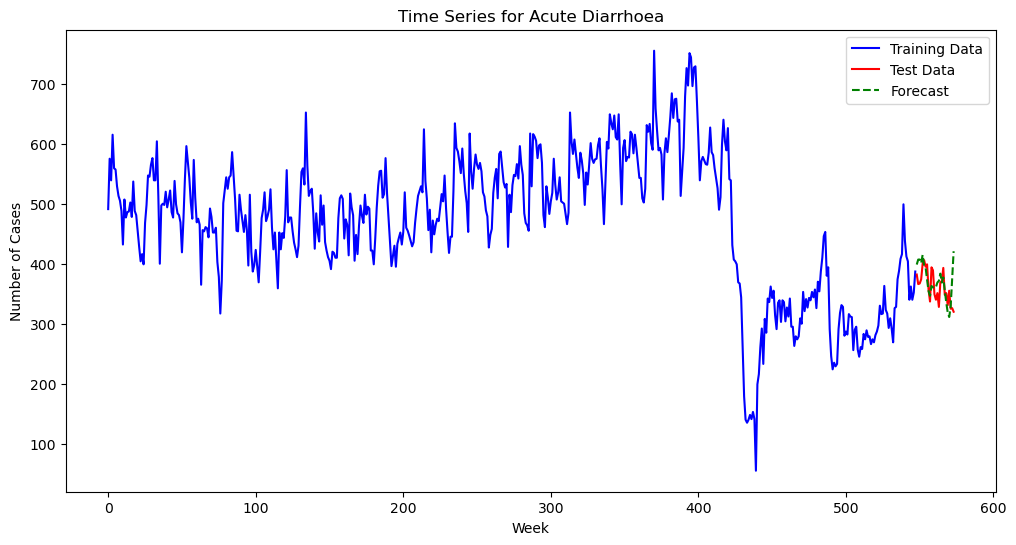

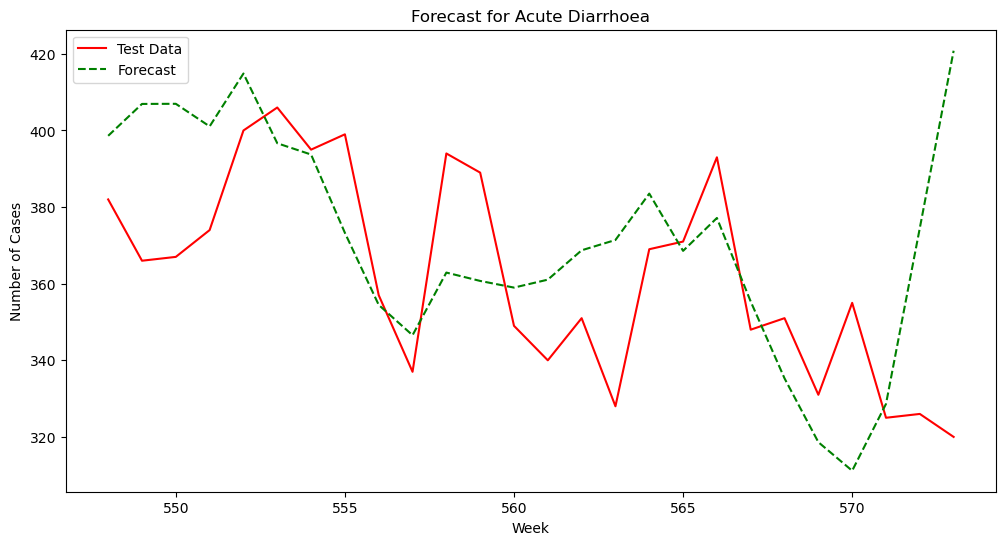

In [114]:
train_acute_diarrhoea = acute_diarrhoea_df[acute_diarrhoea_df["epi_week"] <= "2022-W26"].drop(columns=["disease", "epi_week"])
test_acute_diarrhoea = acute_diarrhoea_df[acute_diarrhoea_df["epi_week"] > "2022-W26"].drop(columns=["disease", "epi_week"])
acute_diarrhoea_model = SARIMAX(
    train_acute_diarrhoea.values, 
    order=(2, 0, 0), 
    seasonal_order=(1, 1, 1, seasonal_period)
)
model_fit = acute_diarrhoea_model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_diarrhoea))

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_acute_diarrhoea.index, train_acute_diarrhoea['no._of_cases'], label='Training Data', color='blue')

# Plot test data
plt.plot(test_acute_diarrhoea.index, test_acute_diarrhoea['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_diarrhoea.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Time Series for Acute Diarrhoea')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()

# Plotting the second plot
plt.figure(figsize=(12, 6))

# Plot test data
plt.plot(test_acute_diarrhoea.index, test_acute_diarrhoea['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_diarrhoea.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Forecast for Acute Diarrhoea')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()

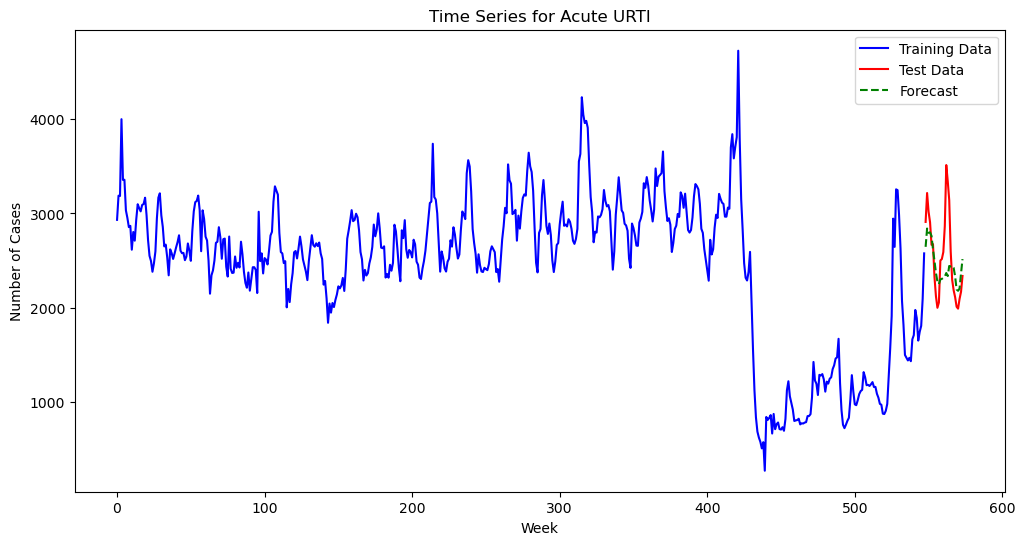

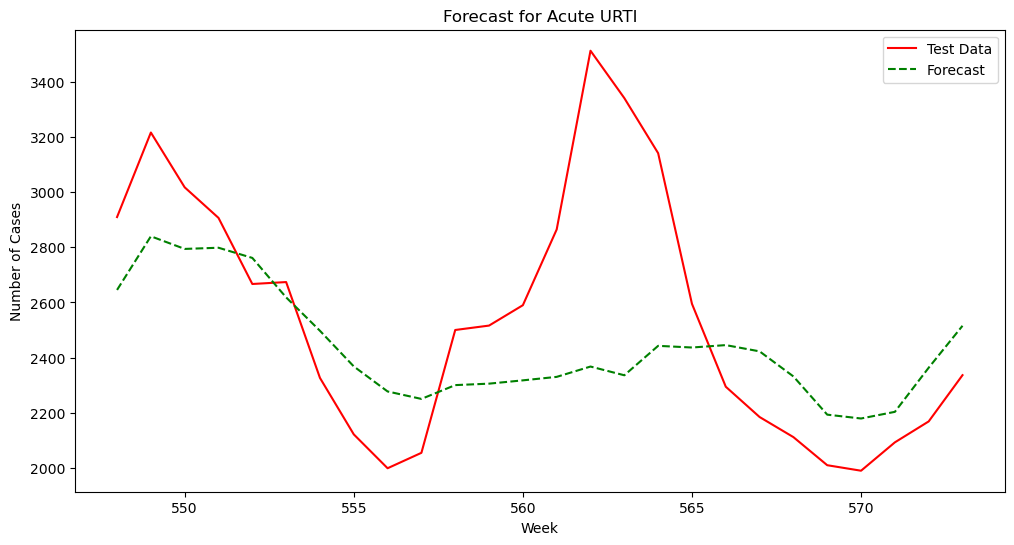

In [116]:
train_acute_urti = acute_urti_df[acute_diarrhoea_df["epi_week"] <= "2022-W26"].drop(columns=["disease", "epi_week"])
test_acute_urti = acute_urti_df[acute_diarrhoea_df["epi_week"] > "2022-W26"].drop(columns=["disease", "epi_week"])
acute_urti_model = SARIMAX(
    train_acute_urti.values, 
    order=(0, 1, 2), 
    seasonal_order=(1, 1, 1, seasonal_period)
)
model_fit = acute_urti_model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_urti))

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_acute_urti.index, train_acute_urti['no._of_cases'], label='Training Data', color='blue')

# Plot test data
plt.plot(test_acute_urti.index, test_acute_urti['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_urti.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Time Series for Acute URTI')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()

# Plotting the second plot
plt.figure(figsize=(12, 6))

# Plot test data
plt.plot(test_acute_urti.index, test_acute_urti['no._of_cases'], label='Test Data', color='red')

# Plot forecast data
forecast_index = test_acute_urti.index
plt.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='--')

# Add labels, title, and legend
plt.title('Forecast for Acute URTI')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()

# Show plot
plt.show()